### Predict and evaluate
- **predict**: create a model, load the trained weights and predict
- **evaluate**: compare the predictions to the ground truth, compute metrics (precision, recall, PR_AUC) and plot curves

In [2]:
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import help_functions as hf
from matplotlib import pyplot as plt
from os.path import exists

### Select the training configuration

In [3]:
# ================== HYPER-PARAMETERS ==================

from configs import configs
config = configs[0]

old_stdout = sys.stdout
if not exists(config['results_folder'] + '/log_eval.txt'):
    log_file = open(config['results_folder'] + '/log_eval.txt', 'w')
else:
    raise FileExistsError
sys.stdout = log_file

In [51]:
test, df = hf.get_flow(df_file=config['data_folder'] + '/test_df.json.bz2',
                      batch_size=config['batch_size'],
                      image_dimension=config['image_dimension'])
y_true_test = hf.get_y_true(shape=(test.samples, len(test.class_indices)), 
                            classes=test.classes)
label_frequencies = y_true_test.sum(axis=0) / y_true_test.sum()

In [5]:
THRESHOLD_MOVE = True

Load test set

In [13]:
# Create model
if config['hierarchical']:
    # model = HierarchicalModel(nr_labels=len(test.class_indices), image_dimension=config['image_dimension'])
    pass
else:
    print('creating model')
    model = hf.create_model(n_labels=len(test.class_indices), image_dimension=config['image_dimension'])
# latest = tf.train.latest_checkpoint(config['results_folder'])
best = 'results_paper/230709_sample_weight_200epochs/cp-0180.ckpt' # manually check in plot graph what is the value with greatest f1-score
model.load_weights(best)

/home/matvieir/anaconda3/lib/python3.8/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


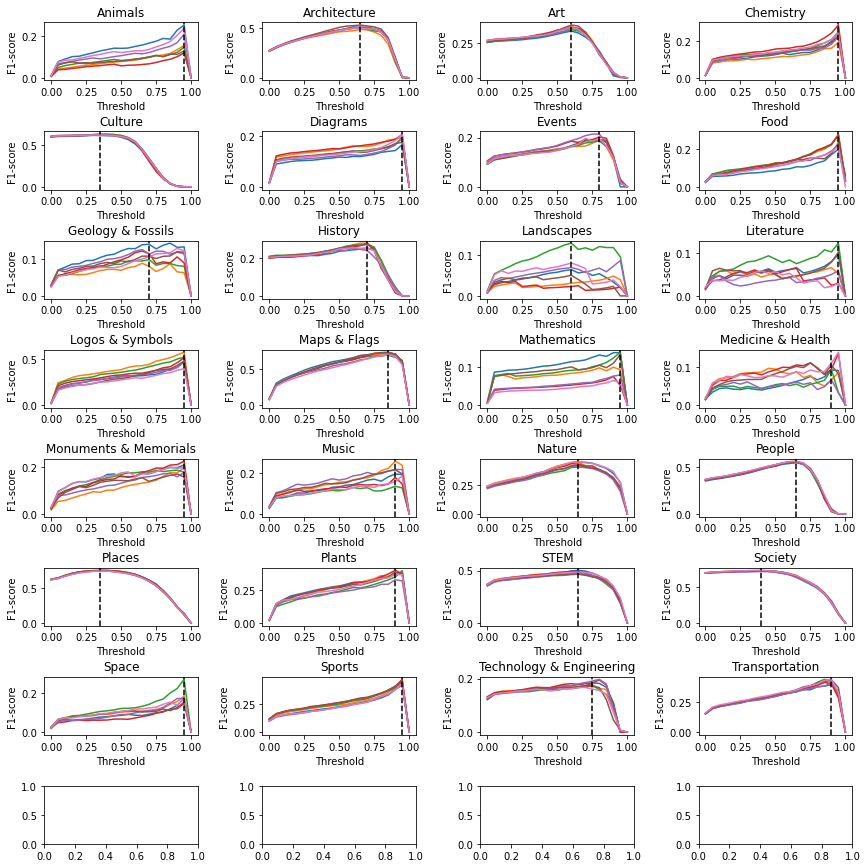

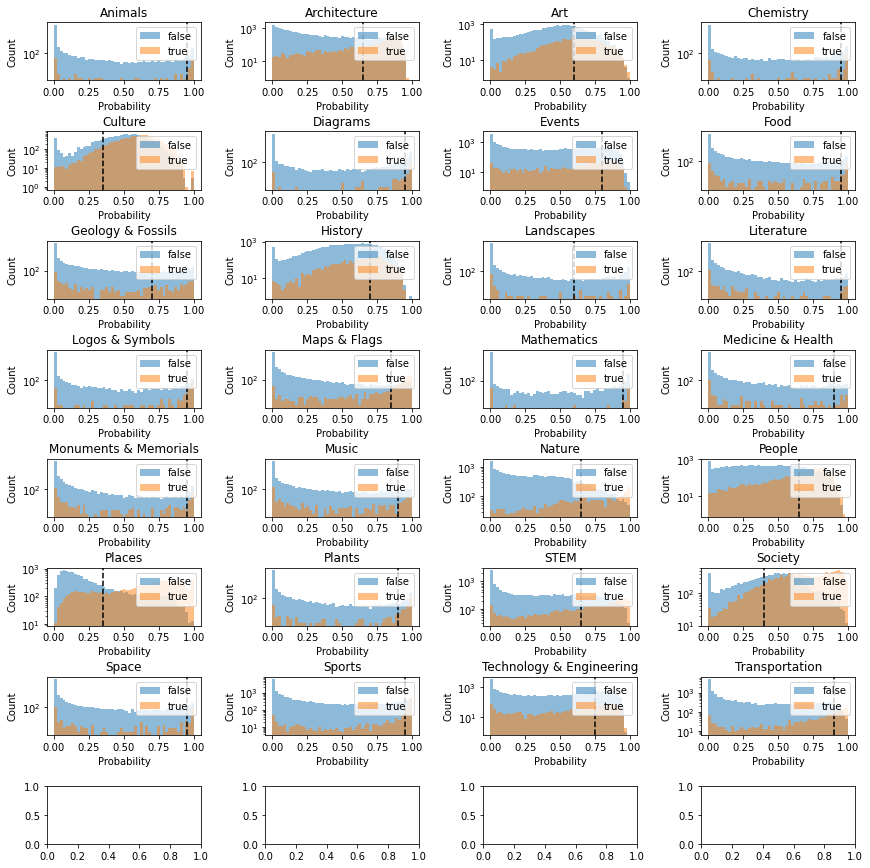

In [14]:
# Predict on test set
print('Predicting on test set:\n')
probs_test = model.predict(test, verbose=1)
print('finished predicting')
y_true_test = hf.get_y_true(shape=(test.samples, len(test.class_indices)), 
                            classes=test.classes)
y_pred_test_05 = 1 * (probs_test > 0.5)

if THRESHOLD_MOVE:
    val_threshold, _ = hf.get_flow(df_file=config['data_folder'] + '/thresh_df.json.bz2',
                                   batch_size=config['batch_size'],
                                   image_dimension=config['image_dimension'])
    # Use the second validation set to the thresholds that optimize f1-score
    print('Predicting on validation set:\n')
    probs_val = model.predict(val_threshold, verbose=1)
    y_true_val = hf.get_y_true(shape=probs_val.shape, classes=val_threshold.classes)

    optim_thresholds = hf.get_optimal_threshold(y_true=y_true_val, 
                                            probs=probs_val, 
                                            thresholds=np.linspace(start=0, stop=1, num=21), 
                                            labels=list(val_threshold.class_indices.keys()), 
                                            N=7,
                                            image_path=config['results_folder'])
    print(optim_thresholds)
    y_pred_test_per_class_threshold = 1 * (probs_test > optim_thresholds)

In [15]:
optim_thresholds

array([0.95, 0.65, 0.6 , 0.95, 0.35, 0.95, 0.8 , 0.95, 0.7 , 0.7 , 0.6 ,
       0.95, 0.95, 0.85, 0.95, 0.9 , 0.95, 0.9 , 0.65, 0.65, 0.35, 0.9 ,
       0.65, 0.4 , 0.95, 0.95, 0.75, 0.9 ])

In [23]:
optim_thresholds.tolist()

[0.9500000000000001,
 0.65,
 0.6000000000000001,
 0.9500000000000001,
 0.35000000000000003,
 0.9500000000000001,
 0.8,
 0.9500000000000001,
 0.7000000000000001,
 0.7000000000000001,
 0.6000000000000001,
 0.9500000000000001,
 0.9500000000000001,
 0.8500000000000001,
 0.9500000000000001,
 0.9,
 0.9500000000000001,
 0.9,
 0.65,
 0.65,
 0.35000000000000003,
 0.9,
 0.65,
 0.4,
 0.9500000000000001,
 0.9500000000000001,
 0.75,
 0.9]

In [44]:
mydf = pd.DataFrame(probs_test, columns=list(test.class_indices.keys()))
mydf['url'] = df.url.values
mydf['heuristic_labels'] = df.labels.values
mydf.head()

# Append the optimal thresholds to the end of the dataframe
mydf.loc[len(mydf.index)] = optim_thresholds.tolist() + ['None', 'OPTIMAL F1 SCORE THRESHOLDS']

mydf.to_json('results_paper/probs_df_120723_sample_weights_200_epochs.json.bz2', compression='bz2')


### Distribution of predictions

In [45]:
pctgs = [round(100 * pctg, 4) for pctg in y_pred_test_05.sum(axis=0) / y_pred_test_05.sum().sum()]
print('\n---------- DISTRIBUTION OF PREDICTIONS ----------')
print(dict(zip(list(test.class_indices.keys()), pctgs)))
if THRESHOLD_MOVE:
    pctgs = [round(100 * pctg, 4) for pctg in y_pred_test_per_class_threshold.sum(axis=0) / y_pred_test_per_class_threshold.sum().sum()]
    print('\n---------- DISTRIBUTION OF PREDICTIONS (individual thresholds) ----------')
    print(dict(zip(list(test.class_indices.keys()), pctgs)))

In [46]:
def plot_f1_scores_side_by_side(f1_scores_05, f1_scores_thresh, image_path):
    plt.figure(figsize=(12, 6))
    x_axis = np.arange(len(f1_scores_05.keys()))
    plt.bar(x_axis-0.1, f1_scores_05.values, width=0.2, label='Threshold 0.5')
    plt.bar(x_axis+0.1, f1_scores_thresh.values, width=0.2, label='Per-class threshold')
    plt.legend(fontsize=12)
    _ = plt.xticks(x_axis, f1_scores_05.keys(), rotation=70, rotation_mode='anchor', ha="right", fontsize=14)
    # plt.title('F1-scores comparison')
    plt.ylabel('F1-score')
    plt.xlabel('Label')
    try:
        plt.savefig(image_path + '/f1-scores-threshold-moving-or-05.png', bbox_inches='tight')
    except:
        print('Could not save image...')

/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matvieir/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


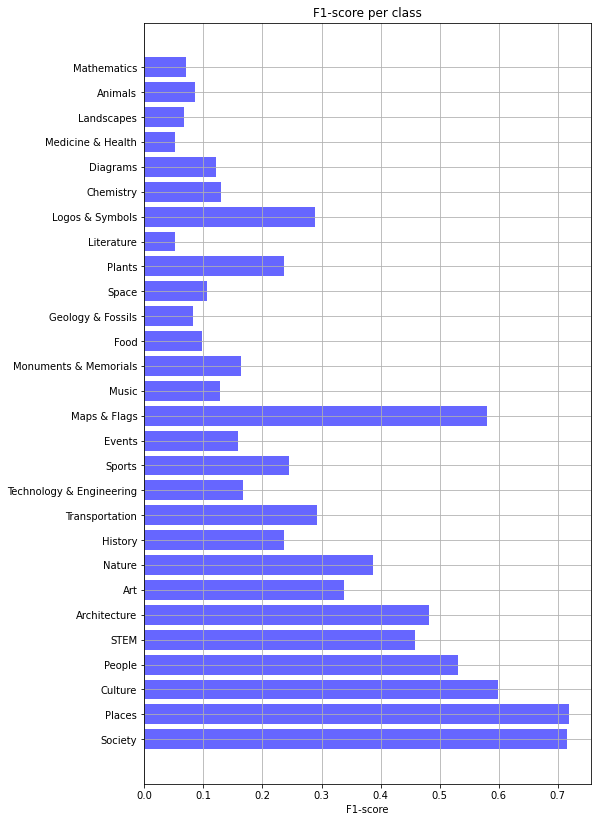

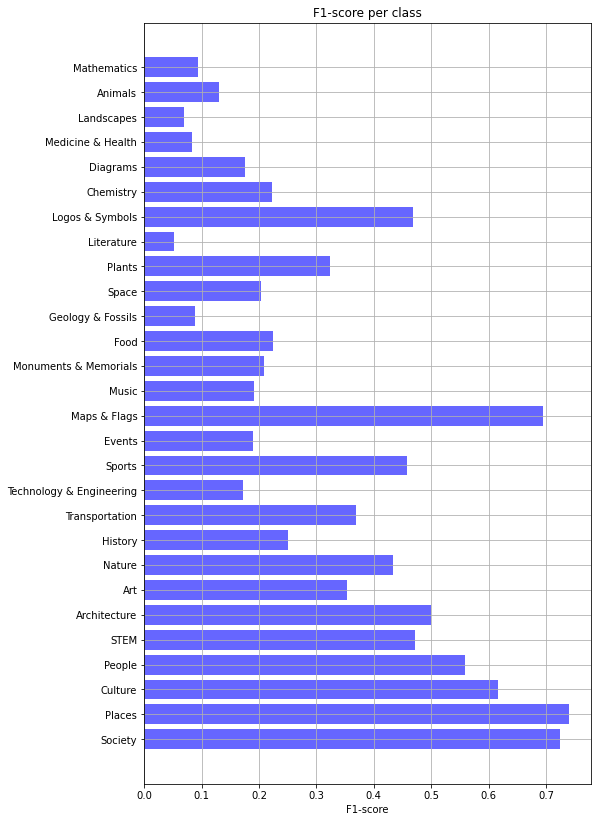

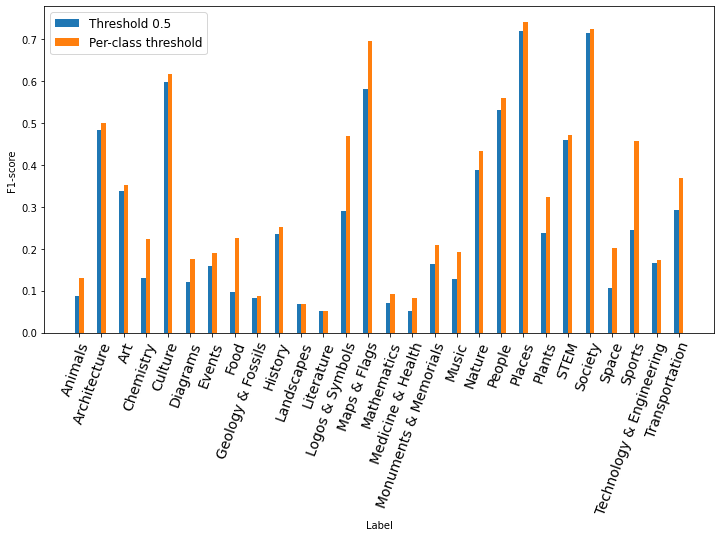

In [47]:
# ================== GET METRICS ======================
print('METRICS FOR THRESHOLD 0.5')
f1_scores_05 = hf.get_metrics(y_true_test, y_pred_test_05, label_names=list(test.class_indices.keys()), image_path=config['results_folder'] + '/f1_scores.png')

if THRESHOLD_MOVE:
    print('METRICS WHEN HAVING PER-CLASS THRESHOLDS')
    f1_scores_thresh = hf.get_metrics(y_true_test, y_pred_test_per_class_threshold, label_names=list(test.class_indices.keys()), image_path=config['results_folder'] + '/f1_scores.png')
    plot_f1_scores_side_by_side(f1_scores_05, f1_scores_thresh, config['results_folder'])

### Precision recall curve

<Figure size 1080x720 with 0 Axes>

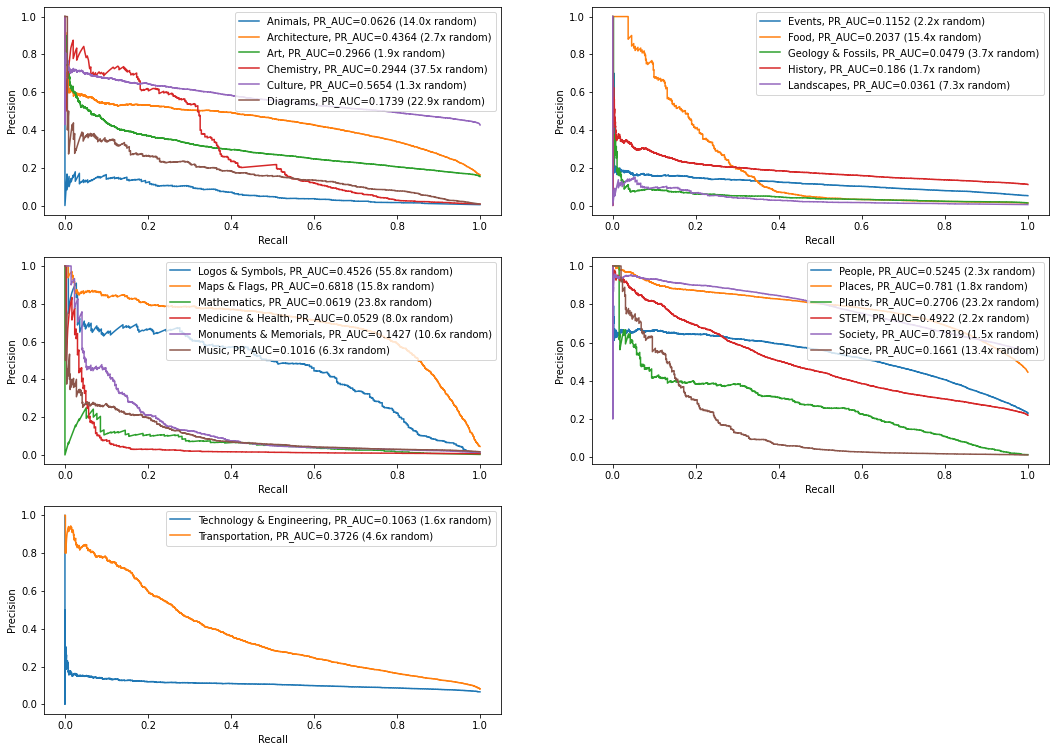

<Figure size 432x288 with 0 Axes>

In [48]:
from sklearn.metrics import precision_recall_curve, auc

# precision recall curve
def plot_pr_curve(y_true, probs, label_names):
    plt.figure(figsize=(15,10))
    precision = dict()
    recall = dict()
    pr_auc = dict()
    random_auc = dict()
    n_images = y_true.shape[0]
    n_labels = len(label_names)

    for i in range(n_labels):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], probs[:, i])
        pr_auc[i] = auc(recall[i], precision[i])
        random_auc[i] = y_true[:, i].sum() / n_images

    plt.figure(figsize=(18, 13))
    
    plt.subplot(3, 2, 1)
    for i in range(0, 6):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 2)
    for i in range(6, 11):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 3)
    for i in range(12, 18):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 4)
    for i in range(19, 25):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')

    plt.subplot(3, 2, 5)
    for i in range(26, 28):
        plt.plot(recall[i], precision[i], label=f'{label_names[i]}, PR_AUC={round(pr_auc[i], 4)} ({round(pr_auc[i]/random_auc[i], 1)}x random)')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.legend(loc='upper right')
    plt.show()
    hf.save_img(config['results_folder'] + '/pr_curve.png')
    
    return precision, recall, pr_auc, random_auc

precision, recall, pr_auc, random_auc = plot_pr_curve(y_true_test, probs_test, list(test.class_indices.keys()))


In [52]:
metrics_dict = dict()
metrics_dict['label_name'] = list(test.class_indices.keys())
metrics_dict['pr_auc'] = list(pr_auc.values())
metrics_dict['random_auc'] = list(random_auc.values())
metrics_dict['frequency'] = label_frequencies
metrics_df = pd.DataFrame(metrics_dict)
metrics_df['better_than_random'] = round(metrics_df['pr_auc'] / metrics_df['random_auc'], 3)
macro_pr_auc = metrics_df['pr_auc'].sum() / len(metrics_df)
print(f'\n\n-------------------------- PR AUC metrics table -----------------------')
print(f'Macro PR_AUC is: {macro_pr_auc}')
print(metrics_df)
metrics_df.head(31)

,label_name,pr_auc,random_auc,frequency,better_than_random
0,Animals,0.062611,0.004467,0.001570,14.017
1,Architecture,0.436404,0.160378,0.056380,2.721
2,Art,0.296578,0.153511,0.053966,1.932
3,Chemistry,0.294401,0.007844,0.002758,37.530
4,Culture,0.565441,0.425889,0.149718,1.328
5,Diagrams,0.173933,0.007600,0.002672,22.886
6,Events,0.115176,0.052111,0.018319,2.210
7,Food,0.203726,0.013222,0.004648,15.408
8,Geology & Fossils,0.047853,0.013044,0.004586,3.668
9,History,0.186040,0.110467,0.038834,1.684


In [53]:
print('\n\n----------------------Sorted by the best PR_AUC-------------------')
print(metrics_df.sort_values('pr_auc', ascending=False))
metrics_df.sort_values('pr_auc', ascending=False)

,label_name,pr_auc,random_auc,frequency,better_than_random
23,Society,0.781929,0.533689,0.187615,1.465
20,Places,0.781029,0.444489,0.156257,1.757
13,Maps & Flags,0.681766,0.043022,0.015124,15.847
4,Culture,0.565441,0.425889,0.149718,1.328
19,People,0.524516,0.229200,0.080574,2.288
22,STEM,0.492158,0.219578,0.077191,2.241
12,Logos & Symbols,0.452646,0.008111,0.002851,55.806
1,Architecture,0.436404,0.160378,0.056380,2.721
18,Nature,0.436106,0.133822,0.047044,3.259
25,Sports,0.409631,0.060622,0.021311,6.757


In [8]:
sys.stdout = old_stdout

log_file.close()